# Sensicorn Suport Data

To interpret the data collected by the project we need some context. This notebook builds and views that contextual data.

The first section loads all the information we need, then the second section shows it. partially to give some understanding and context, and partially to make sure that it is all coherent.

In [1]:
import helpers
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry.polygon import LinearRing
from scipy.misc import imread

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

## TODO: 

* ARR to help write up the graph generation process
* redraw ladies toilets so that outer goes to the walls
* Regenerate boundaries so that isovist and inner are different
* rebuild graph and transfer coords across

# Graph for movement

We have a traversable graph that can be used for working out (approx) shortest paths between two places. It's also going to be useful in generating a graph based probability of where someone is now based on where they were the step before.

* Drawing the graph takes a very long time!
* Writing the graph files only takes 2.5 seconds for ~50k edges (I'm quite pleased about that!)
* Constructing the graph only takes 2-3 seconds, and I think most of that is file loading.


There are two files, one has nodes and the other has edges.

Nodes rows look like: `(0, {'x':64852, 'y':-16490})`

and Edge rows like this: `(431, 436, {'weight': 340})`

Edge weights can be tuned in grasshopper to account for _creepy factor_ for now, but eventually it'd be good to tune them automatically. The `x` and `y` attributes are so that we can draw the graph as it's constructed to be sure that it all works.

In [2]:
f = open('infrastructure/nodes.g', 'r')
nodes = f.readlines()
f.close()
nodes = [eval(n) for n in nodes]

OG = nx.Graph()
for n in nodes:
    OG.add_node(*n)
    
print OG.number_of_nodes(), "nodes"

4845 nodes


In [3]:
f = open('infrastructure/edges.g', 'r')
edges = f.readlines()
f.close()
edges = [eval(n) for n in edges]

for e in edges:
    OG.add_edge(*e)

print OG.size(), "edges"

12083 edges


This really shouldn't be disjoint, but it seems like there's only a little bit that's misbehaving. THe more interesting thing is that this graph is known to be planar and it's not drawing that way. I guess drawing graphs is hard!

In [55]:
nx.draw(OG, alpha=0.3, s=1, node_shape=".", node_size=30) 
# It seems from this version (spring) of the graph that some sections of the graph are disjoint. Check this with the real data once we have it!

In [6]:
def read_boundaries(file_name):
    f = open(file_name, 'r')
    verts = f.readlines()
    f.close()
    edges = [eval(v) for v in verts]
    return edges

inner   = read_boundaries("infrastructure/inner_boundaries.wires")
isovist = read_boundaries("infrastructure/isovist_boundaries.wires")
outer   = read_boundaries("infrastructure/outer_boundaries.wires")

To see why the graph goes where it does it's helpful to put some context in.

_TODO: inner and isovist are sharing the same data for some reason. Reexport it from GH and get it right!_

# Fixed locations

## Stickers
The stickers are the locating items in the space. They are stuck to the ceiling at roughly 2m intervals.

![](ladder.gif)

They have a QR code on them, so they can be scaned with a phone. That gives us a time stamp and a location.

In future we should be able to get orientation and position in field of view because QR codes have a top.

In [7]:
stickerLocations = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/1sijQZR2iFLo2FS_3r5gbsuAkaglRz557LWjdLxnPkpE/pub?gid=0&single=true&output=csv")
stickerLocations = stickerLocations.drop(["raw","z"], 1) # this is just because we aren't on multiple floors
stickerLocations.head(3)

,stickerID,x,y
0,1,63852.09440,-13561.617780
1,2,62985.85359,-11830.460440
2,3,62985.85359,-9830.460444


## Base Station (Agent) Locations

These are the Raspberry Pi computers that recieve the beacon packets.

We use the terms _agent_ and _base station_ interchangably at the moment. In the future we will probably use _agent_ to mean a simulated occupant, so expect to see _base station_ used more.

I introduced these in a blog post a while ago and explained what the sections were for:

![](base_segments.png)

> In the image above, section B is where the brain lives; this is a Raspberry Pi 3. It does all the processing and network communication that we need. It’s probably huge overkill for what we’re asking it to do, but it gives us a lot of future expansion options1.

> Section C is open to the air, it’s going to have environmental sensors in it. We’ll be measuring temperature, humidity, noise levels and maybe air movement. If you can think of anything else that we should be measuring then let us know.

> Section A answers all the people who were thinking “_It’s horribly dark at my desk, why aren’t you measuring light levels?_” We’re trying to be a bit smart about this. Light levels need to be measured in a particular place, so using a light sensor will only tell us what it’s like where the light sensor is. We’re going to use a camera; it’s like the equivalent of using 8 million2 light sensors.

In [8]:
baseStationData = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/167pxh_NRq5e9sQV9Zb8Z-Q-kdN7Zy9FCzCp47eVXTuE/pub?gid=1446311565&single=true&output=csv")

#only keep the columns we care about
baseStationData = baseStationData.ix[:,0:5]
baseStationData = baseStationData.drop(["location"], 1)
baseStationData = baseStationData[baseStationData.agentId > 0] #not really sure how this works, maybe failure is falsy?
baseStationData.head(3)

,agentId,agentName,x,y
0,00000000e5bd0ae9,Ace,2953.206017,14427.458860
1,000000006c1a3b5a,Alfa,3323.405966,9086.502512
2,0000000020294bbd,Beer,3313.076869,2665.631392


In [9]:
def read_seating_plan(file_name):
    f = open(file_name, 'r')
    verts = f.readlines()
    f.close()
    edges = [eval(v) for v in verts]
    return edges

seats = pd.DataFrame( read_seating_plan("infrastructure/names.xy"))
seats["x"] = seats.apply(lambda x: x.point[0], axis=1)
seats["y"] = seats.apply(lambda x: x.point[1], axis=1)
seats.drop('point', axis=1, inplace=True)
# seats.columns = [u'person_name', u'seat_num', u'x', u'y']
seats.head()

,name,seat_num,x,y
0,Fiona,0,36337.665444,2130.335205
1,Reception,1,37685.272579,3982.198383
2,Reception,2,37811.231191,4977.793720
3,Workshop,3,41977.269425,5059.876140
4,Barry C,4,43544.535418,4170.173374


# Visualisation

In [56]:
def draw_infrastructure(title="Sticker and Base Station Locations", draw_graph=False, draw_img=False, 
                        draw_boundaries=False, draw_axes=False, draw_stickers=False, draw_basestations=False, draw_seat_names=False,
                        pad_x_pc=0.05, pad_y_pc=0.01,
                       sticker_label_size=7, name_label_size=5, base_label_size=10):
    """Draw the fixed infrastructure of the sensicorn project."""
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    
    def plot_line(ob, colour="r"):
        x, y = ob.xy
        plt.plot(x, y, color=colour, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    
    fig, ax = plt.subplots()

    plt.title(title)
    
    legend_items = []
    
    # set axis limits with a bit of padding
    x = [pair[0] for pair in outer[0]] # get boundary limits
    y = [pair[1] for pair in outer[0]]
    pad_y = (max(y) - min(y)) * pad_y_pc
    pad_x = (max(x) - min(x)) * pad_x_pc
    axes = plt.gca()
    axes.set_ylim([min(y) - pad_y, max(y) + pad_y])
    axes.set_xlim([min(x) - pad_x, max(x) + pad_x])
    
    if draw_img:
        # put the image on the graph as an underlay
        img = imread("map.png")
        ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
        #                                [left, right, bottom, top  ]

    if draw_boundaries:
        for boundary_set, colour in [(inner, "r"),(isovist, "g"),(outer, "b")]:
            for e in boundary_set:
                ring = LinearRing(e)
                plot_line(ring, colour)
        legend_inner = mlines.Line2D([], [], color='r', label='Inner Boundary')
        legend_isovist = mlines.Line2D([], [], color='g', label='Isovist Boundary')
        legend_outer = mlines.Line2D([], [], color='b', label='Outer Boundary')
        legend_items.extend([legend_inner, legend_isovist, legend_outer])

    if draw_graph:
        pos = {n[0]: (n[1]["x"], n[1]["y"]) for n in OG.nodes(data=True)}
        nx.draw(OG, alpha=0.3, s=1, pos=pos, node_shape=".", node_size=10)  # don't draw the graph

    if draw_basestations:
        # put the baseStations on the map
        for index, row in baseStationData.iterrows():
            ax.text(row.x, row.y, row.agentName, fontsize=base_label_size)
        base_stations = ax.scatter(baseStationData.x, baseStationData.y, marker='+', label='base stations')
        legend_items.append(base_stations)

    if not draw_axes:
        # Hide the axis numbers because they don't tell us much
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if draw_stickers:
        # the sticker labels
        for _, row in stickerLocations.iterrows():
            ax.text(row.x, row.y, "{0:03d}".format(int(row.stickerID)), fontsize=sticker_label_size)

        # sticker dots
        stickers = ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y", label='stickers')
        legend_items.append(stickers)
    
    if draw_seat_names:
        for _, row in seats.iterrows():
            ax.text(row.x, row.y, row["name"], fontsize=name_label_size, rotation=10) # .name must be a reserved word?

        # sticker dots
        seat_pos = ax.scatter(seats.x, seats.y, s=1, c="y", label='seats')
        legend_items.append(seat_pos)
        
    
    if len(legend_items) > 0:
        # red_patch = mpatches.Patch(color='red', label='The red data') # patch example
        plt.legend(handles=legend_items, loc='upper left')

    plt.show()

The base stations and stickers, as viewed on the floor plate.

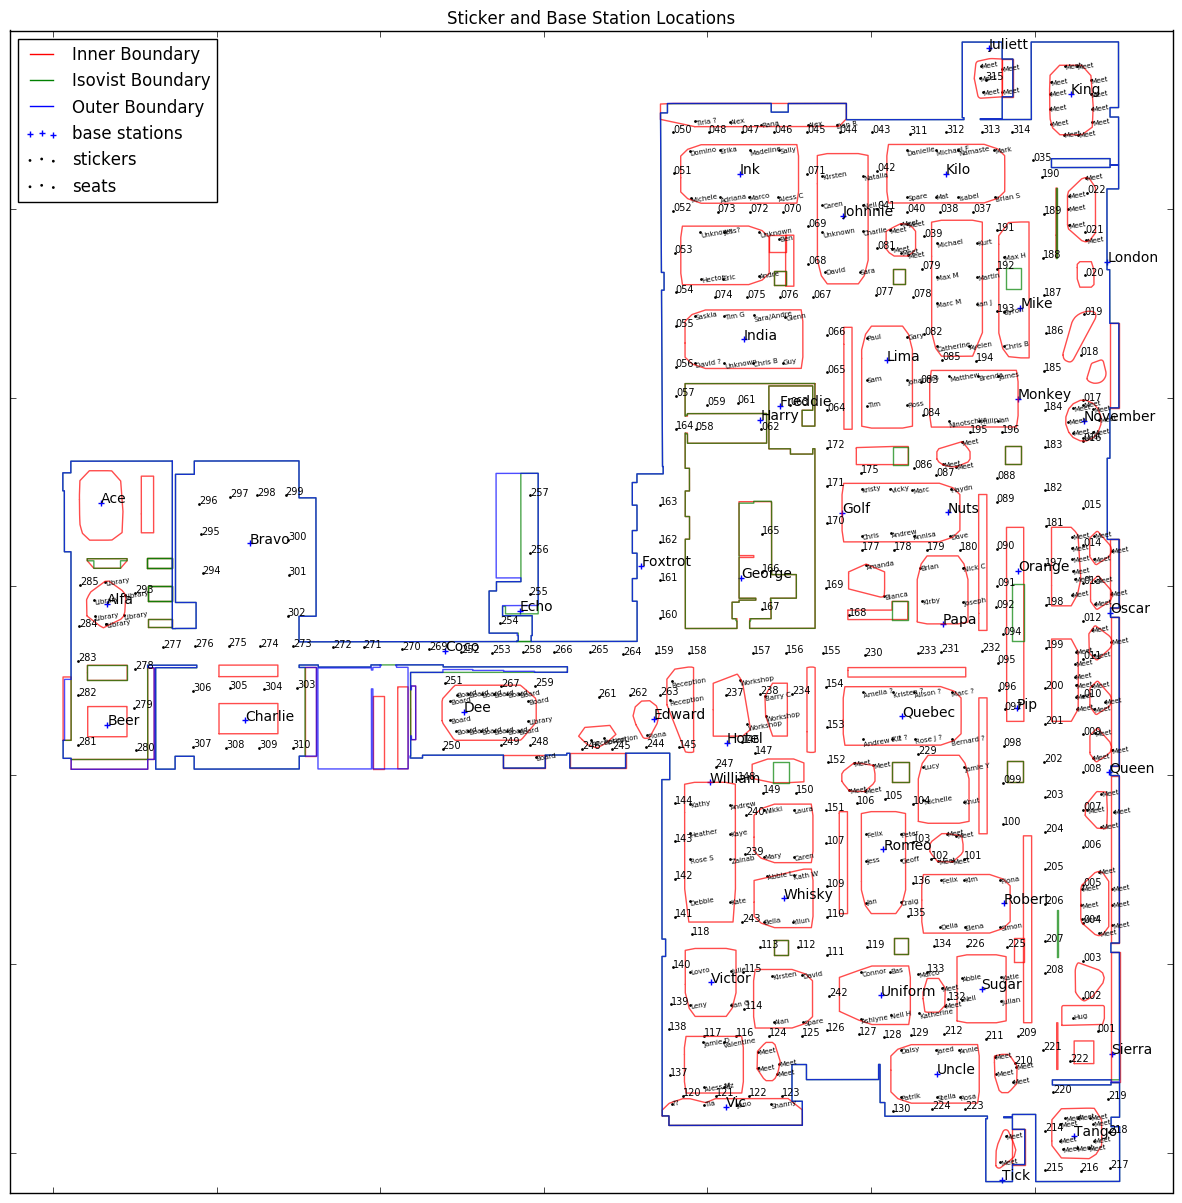

In [11]:
draw_infrastructure(draw_boundaries=True, draw_stickers=True, draw_basestations=True, draw_seat_names=True)

If we draw the graph with the nodes in their initial coordinates then we get this.

(We know that this draws in the plane because that's how we made it!)

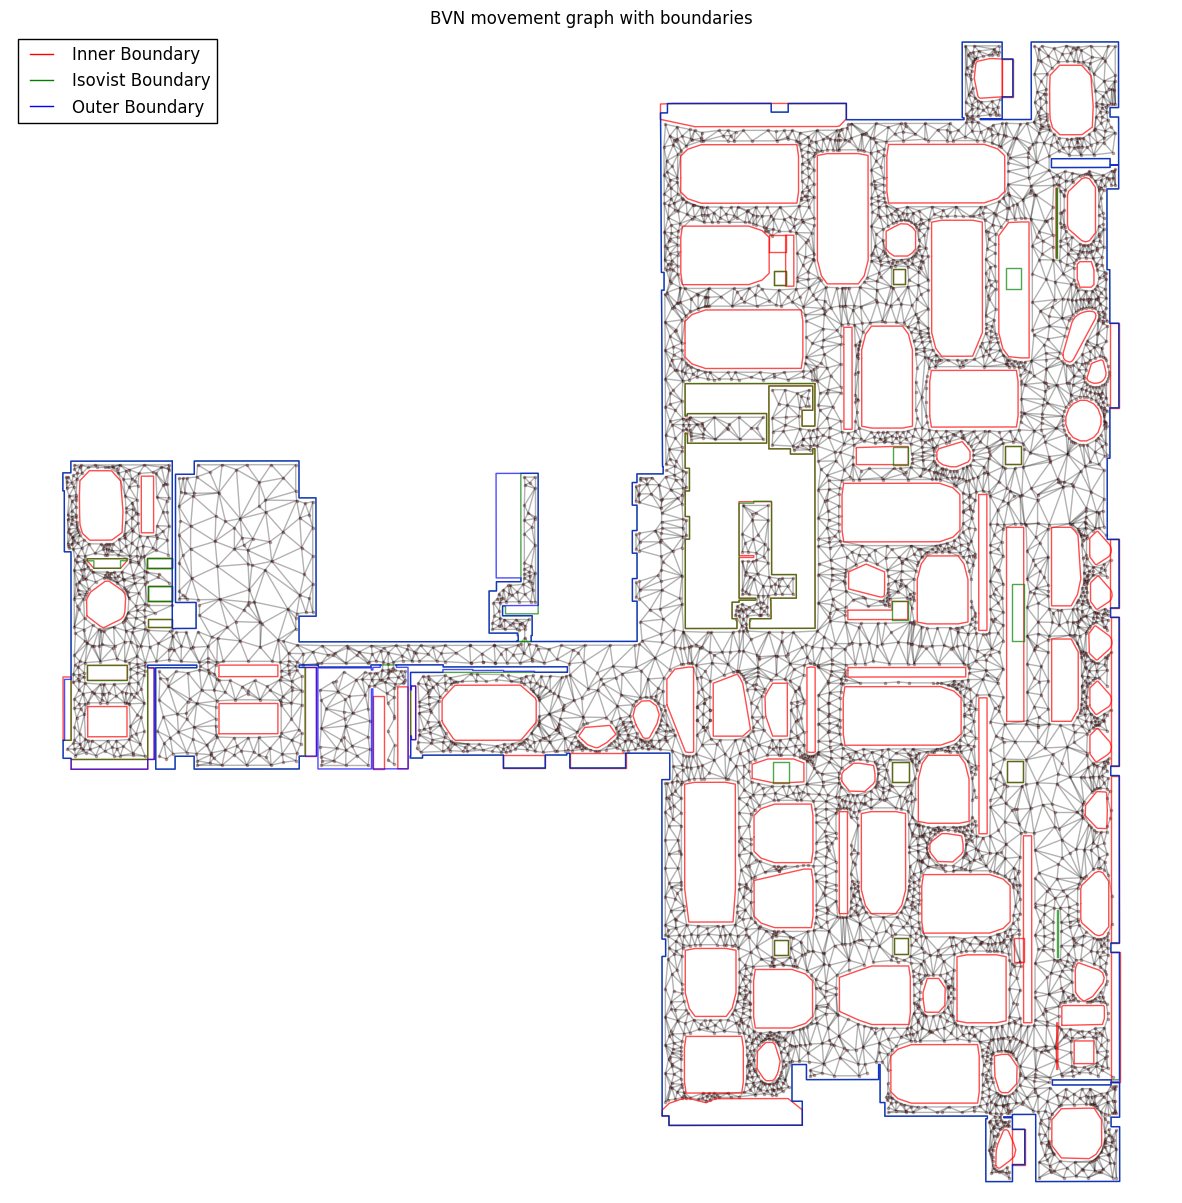

In [12]:
draw_infrastructure(title="BVN movement graph with boundaries", draw_graph=True, draw_boundaries=True)

# Export for future notebooks

Now that we have all this data, let's not waste time importing it again. We can make a file that takes the data and lets us just import that.

The pickle of the graph is just me being lazy and not bothering to read the nx docs for to json.

In [53]:
data = {
            "inner": inner,
            "isovist": isovist,
            "outer": outer,
            "baseStationData": baseStationData.to_dict(),
            "stickerLocations": stickerLocations.to_dict(),
            "seats": seats.to_dict()
        }
with open("infrastructure_store.json", 'w') as f:
    json.dump( data, f)

In [59]:
with open("infrastructure_store.json", "r") as json_data:
    d = json.load(json_data)
#     print d.keys()
    sl = d["stickerLocations"]
    o = d['outer']
    bds = d['baseStationData']
    i = d['inner']
    s = d['seats']
    iso = d['isovist']

nx.write_gpickle(OG, "graph.p")

# print "stickerLocations"    
# print pd.DataFrame.from_dict(sl).head(2)
# print "\n\nbaseStationData"
# print pd.DataFrame.from_dict(bds).head(2)
# print "\n\nouter"
# print o[0]
# print "\n\ninner"
# print i[0]
# print "\n\nseats"
# print pd.DataFrame.from_dict(s).head(2)
# print "\n\nisovist"
# print iso[0]